In [88]:
# 库
import os
import subprocess
import time
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shutil
import os
from IPython.display import clear_output
import json
from datetime import datetime
import os
from kaggle.api.kaggle_api_extended import KaggleApi
# ======================
# 机器学习 & 优化
# ======================
import xgboost as xgb
import optuna
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

# ======================
# 化学信息学 (RDKit)
# ======================
from rdkit import Chem, RDLogger
from rdkit.Chem import (
    Descriptors, Crippen, rdMolDescriptors,
    MACCSkeys, RDKFingerprint, rdFingerprintGenerator
)
from rdkit.Chem.AtomPairs import Pairs, Torsions

# 关闭 RDKit 的警告
RDLogger.DisableLog('rdApp.*')

# Avalon 指纹（可选）
try:
    from rdkit.Avalon import pyAvalonTools
    avalon_available = True
except ImportError:
    avalon_available = False
print(f"Avalon available: {avalon_available}")

# ======================
# 可视化
# ======================
import plotly.io as pio
pio.renderers.default = "iframe_connected"

# ======================
# Jupyter 辅助
# ======================
from IPython.display import clear_output


DATA_DIR = r"C:\Users\Admin\Documents\GitHub\kaggle\Thermophysical Property Melting Point\data"
ITEM_DIR = os.path.join(DATA_DIR, "item")
os.makedirs(ITEM_DIR, exist_ok=True)

MODEL_DIR = os.path.join(ITEM_DIR, "model")
os.makedirs(MODEL_DIR, exist_ok=True)

OPTUNA_DIR = os.path.join(ITEM_DIR, "optuna")
os.makedirs(OPTUNA_DIR, exist_ok=True)

melting_point_DIR = os.path.join(DATA_DIR, "melting-point")
os.makedirs(melting_point_DIR, exist_ok=True)

HISTORY_DIR = os.path.join(DATA_DIR, "HISTORY")
os.makedirs(HISTORY_DIR, exist_ok=True)


Avalon available: True


In [1]:
import xgboost as xgb
print(xgb.__version__)


2.1.1


In [62]:

# 定义路径
merge_fp_path = os.path.join(ITEM_DIR, "merge_fingerprints.csv")
test_fp_path  = os.path.join(ITEM_DIR, "test_fingerprints.csv")

# 读取数据
merge_df = pd.read_csv(merge_fp_path)
test_df  = pd.read_csv(test_fp_path)

# 打印信息
print(f"✅ merge_df 加载完成，shape = {merge_df.shape}")
print(f"✅ test_df  加载完成，shape = {test_df.shape}")

print("特征字段: SMILES, Tm | 描述符: 217 | Morgan: 1024 | FCFP: 1024 | MACCS: 167 | AtomPair: 1024 | RDKit: 2048 | Avalon: 1024")
print("合计特征总数 = 6528")


✅ merge_df 加载完成，shape = (28808, 6530)
✅ test_df  加载完成，shape = (666, 6530)
特征字段: SMILES, Tm | 描述符: 217 | Morgan: 1024 | FCFP: 1024 | MACCS: 167 | AtomPair: 1024 | RDKit: 2048 | Avalon: 1024
合计特征总数 = 6528


In [63]:
print(merge_df.columns)
print(test_df.columns)


Index(['SMILES', 'Tm', 'MaxAbsEStateIndex', 'MaxEStateIndex',
       'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt',
       'HeavyAtomMolWt',
       ...
       'Avalon_1014', 'Avalon_1015', 'Avalon_1016', 'Avalon_1017',
       'Avalon_1018', 'Avalon_1019', 'Avalon_1020', 'Avalon_1021',
       'Avalon_1022', 'Avalon_1023'],
      dtype='object', length=6530)
Index(['id', 'SMILES', 'MaxAbsEStateIndex', 'MaxEStateIndex',
       'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt',
       'HeavyAtomMolWt',
       ...
       'Avalon_1014', 'Avalon_1015', 'Avalon_1016', 'Avalon_1017',
       'Avalon_1018', 'Avalon_1019', 'Avalon_1020', 'Avalon_1021',
       'Avalon_1022', 'Avalon_1023'],
      dtype='object', length=6530)


In [64]:
import matplotlib.pyplot as plt
import matplotlib

# 设置中文字体，避免乱码
plt.rcParams['font.sans-serif'] = ['SimHei']        # 黑体
plt.rcParams['axes.unicode_minus'] = False          # 解决负号显示成方块的问题


merge_df 各区间数量：
0% - 10% : 4122 列
10% - 20% : 1702 列
20% - 30% : 385 列
30% - 40% : 106 列
40% - 50% : 45 列
50% - 60% : 39 列
60% - 70% : 43 列
70% - 80% : 25 列
80% - 90% : 9 列
90% - 100% : 54 列

test_df 各区间数量：
0% - 10% : 5904 列
10% - 20% : 345 列
20% - 30% : 91 列
30% - 40% : 47 列
40% - 50% : 55 列
50% - 60% : 16 列
60% - 70% : 11 列
70% - 80% : 4 列
80% - 90% : 6 列
90% - 100% : 51 列


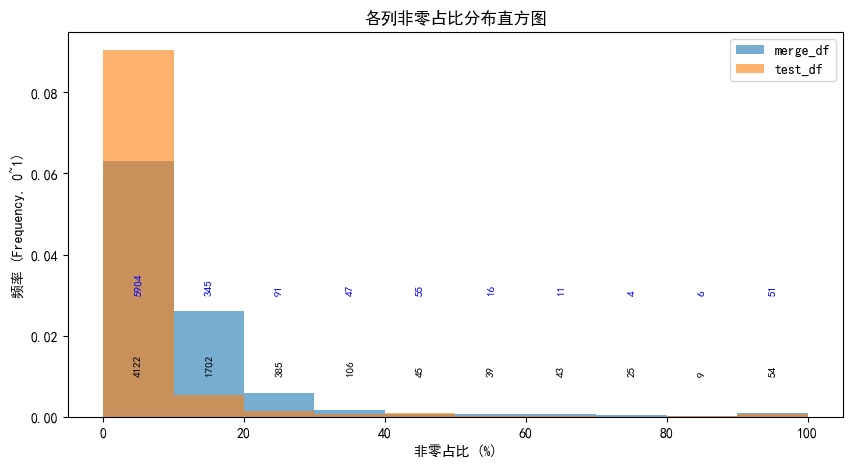

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# 逐列非零占比（百分比形式）
merge_ratio = merge_df.apply(lambda col: (col != 0).mean() * 100)
test_ratio  = test_df.apply(lambda col: (col != 0).mean() * 100)

plt.figure(figsize=(10,5))

size = 10
# 绘制直方图 (频率形式)
counts1, bins1, patches1 = plt.hist(merge_ratio, bins=size, alpha=0.6, 
                                    label="merge_df", density=True)
counts2, bins2, patches2 = plt.hist(test_ratio, bins=size, alpha=0.6, 
                                    label="test_df", density=True)

# 分别计算数量（而不是频率）
merge_counts, _ = np.histogram(merge_ratio, bins=bins1)
test_counts, _ = np.histogram(test_ratio, bins=bins2)



# 先确定区间（bins）
bins = np.linspace(0, 100, size + 1)   # 20 个区间，0%~100%

# 打印结果
print("merge_df 各区间数量：")
for i in range(len(bins)-1):
    print(f"{bins[i]:.0f}% - {bins[i+1]:.0f}% : {merge_counts[i]} 列")

print("\ntest_df 各区间数量：")
for i in range(len(bins)-1):
    print(f"{bins[i]:.0f}% - {bins[i+1]:.0f}% : {test_counts[i]} 列")


# 在柱子上标注数量
for c, b in zip(merge_counts, bins1[:-1]):
    if c > 0:
        plt.text(b + (bins1[1]-bins1[0])/2, 0.01, str(c), 
                 ha="center", va="bottom", fontsize=8, color="black", rotation=90)

for c, b in zip(test_counts, bins2[:-1]):
    if c > 0:
        plt.text(b + (bins2[1]-bins2[0])/2, 0.03, str(c), 
                 ha="center", va="bottom", fontsize=8, color="blue", rotation=90)

plt.xlabel("非零占比 (%)")
plt.ylabel("频率 (Frequency, 0~1)")
plt.title("各列非零占比分布直方图")
plt.legend()
plt.show()


In [66]:
# 数据拆分 (训练集与测试集)
# ============================================
# 特征字段: SMILES, Tm | 描述符: 217 | Morgan: 1024 | FCFP: 1024 | MACCS: 167 | AtomPair: 1024 | RDKit: 2048 | Avalon: 1024
# 合计特征总数 = 6528


# # 构建训练集与测试集
# # 1. 找到重复的 SMILES
# dup_smiles = set(merge_df['SMILES']) & set(test_df['SMILES'])
# print(f"⚠️ 检测到 {len(dup_smiles)} 个重复 SMILES")

# # 2. 删除 merge_df 里 SMILES 在 test_df 里的行
# before_shape = merge_df.shape
# merge_df = merge_df[~merge_df['SMILES'].isin(test_df['SMILES'])].reset_index(drop=True)
# after_shape = merge_df.shape

# print(f"✅ 删除完成: 从 {before_shape} → {after_shape}")



# 随机选取部分特征（示例：50 个）
np.random.seed(42)
selected_features = np.random.choice(
    merge_df.drop(columns=['SMILES', 'Tm']).columns,
    size=5,
    replace=False
)
sample_len = 1000
x = merge_df.iloc[:sample_len][selected_features]   # 训练特征 (前 1000 条)
y = merge_df.iloc[:sample_len]['Tm']               # 训练目标
x_test = test_df[selected_features]          # 测试特征 (同样的特征列)


x = merge_df.drop(labels=['SMILES', 'Tm'], axis=1)      # 特征矩阵 X：去掉 SMILES 和目标值 Tm
y = merge_df['Tm']                                      # 目标向量 y：只保留 Tm (熔点，单位 K)
x_test = test_df.drop(labels=['SMILES', 'id'], axis=1)  # 测试集特征：去掉 SMILES 和 id (因为 test 没有 Tm)




# 3. 打印维度信息
print("📊 数据拆分完成")
print(f"训练集特征 x        shape   : {x.shape}")
print(f"训练集目标 y        shape   : {y.shape}")
print(f"测试集特征 X_test   shape   : {x_test.shape}")
print(f"x 类型: {type(x)}")







📊 数据拆分完成
训练集特征 x        shape   : (28808, 6528)
训练集目标 y        shape   : (28808,)
测试集特征 X_test   shape   : (666, 6528)
x 类型: <class 'pandas.core.frame.DataFrame'>


In [91]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

# 假设 merge_df 是训练数据（去掉 ID, label 等非特征列）
X = x  # 如果有 id/标签列记得去掉
X_sparse = sparse.csr_matrix(X.values)

# 目标维度（比如从几千维降到 100 维）
n_components = 100  

svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced_array = svd.fit_transform(X_sparse)

# 包装成 DataFrame，保留索引
X_reduced = pd.DataFrame(
    X_reduced_array,
    index=X.index,  # 保留原行索引
    columns=[f"SVD_{i+1}" for i in range(X_reduced_array.shape[1])]
)

print("原始维度:", X.shape[1])
print("降维后:", X_reduced.shape)
# print(X_reduced.head())

# 方差解释率
explained_var = svd.explained_variance_ratio_.sum()
print(f"累计解释方差比: {explained_var:.2%}")


原始维度: 6528
降维后: (28808, 100)
累计解释方差比: 100.00%


In [92]:
from scipy import sparse

# 测试集降维
x_test_reduced_array = svd.transform(sparse.csr_matrix(x_test.values))

# 包装成 DataFrame，保持行索引一致
x_test_reduced = pd.DataFrame(
    x_test_reduced_array,
    index=x_test.index,  # 保留原始行索引
    columns=[f"SVD_{i+1}" for i in range(x_test_reduced_array.shape[1])]
)

print("原始维度:", x_test.shape[1])
print("降维后:", x_test_reduced.shape)
# print(x_test_reduced.head())


原始维度: 6528
降维后: (666, 100)


In [104]:
def run_kfold_xgb(x, y, x_test, params, HISTORY_DIR, K_FOLDS=5, verbose=0):
    """
    使用 Stratified K-Fold + XGBoost 进行训练验证，并保存实验结果

    参数:
        x, y        : 训练集特征和标签
        x_test      : 测试集特征
        params : XGBoost 最优参数 (dict)
        ITEM_DIR    : 保存结果的根目录
        K_FOLDS     : 折数 (默认=5)
        random_state: 随机种子
    """


    # 使用 Stratified K-Fold + XGBoost 进行训练验证

    time_str = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
    history_DIR = os.path.join(HISTORY_DIR, time_str)
    os.makedirs(history_DIR, exist_ok=True)



    # 定义分层 K 折交叉验证
    # K_FOLDS = 5
    skfold = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    # 定义 Yeo-Johnson 变换
    yeo = PowerTransformer(method='yeo-johnson')

    # 初始化存储变量
    oof_val = np.zeros(len(x))       # OOF 预测
    train_score, val_score = [], []  # 每折 MAE
    test_pred = []                   # 每折 test 预测
    fold_records = []                # 保存每折信息
    all_importances = []


    for i, (train_index, val_index) in enumerate(skfold.split(x, pd.qcut(y, q=10).cat.codes), 1):
        print(f"🔄 Fold {i}/{K_FOLDS} 开始...", end="\r", flush=True)
        
        if verbose > 0:
            print(f"🔄 Fold {i}/{K_FOLDS} 开始...")
        start_time = time.time()

        # 1. 数据集划分
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # 2. 目标值 Yeo-Johnson 变换
        y_train = yeo.fit_transform(y_train.values.reshape(-1, 1)).squeeze()
        y_val   = yeo.transform(y_val.values.reshape(-1, 1)).squeeze()

        # 3. 特征选择（轻量级 XGBoost 模型）
        selector_model = xgb.XGBRegressor(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.05,
            random_state=42,
            device='cpu',
            objective="reg:absoluteerror",
            tree_method='hist',
            verbosity=0
        )
        selector_model.fit(x_train, y_train)

        # 使用 SelectFromModel 保留重要特征
        selector = SelectFromModel(selector_model, prefit=True, threshold="mean")
        selected_idx = selector.get_support(indices=True)
        selected_features = x_train.columns[selected_idx].tolist()
        if verbose > 0:
            print(f"✅ 选择的特征数量: {len(selected_features)}")

        # 4. 保留重要特征
        x_train_new = x_train[selected_features]
        x_val_new   = x_val[selected_features]
        x_test_new  = x_test[selected_features]

        # 5. 转换为 DMatrix
        dtrain = xgb.DMatrix(x_train_new, y_train, feature_names=selected_features)
        dval   = xgb.DMatrix(x_val_new, y_val, feature_names=selected_features)
        dtest  = xgb.DMatrix(x_test_new, feature_names=selected_features)

        # 6. XGBoost 训练
        xgb_model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=params["num_boost_round"],
            evals=[(dtrain, 'train'), (dval, 'valid')],
            early_stopping_rounds=300,
            verbose_eval=(1000 if verbose > 0 else False)
        )

        # 保存模型
        model_path = os.path.join(history_DIR, f"xgb_model_fold{i}.json")
        xgb_model.save_model(model_path)
        if verbose > 0:
            print(f"✅ Fold {i} 的模型已保存到 {model_path}")



        # 7. 获取特征重要性（按 gain）
        importance_dict = xgb_model.get_score(importance_type='gain')
        importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])
        importance_df["Fold"] = i
        all_importances.append(importance_df)

        # 8. 预测
        y_train_pred = xgb_model.predict(dtrain)
        y_val_pred   = xgb_model.predict(dval)
        y_test_pred  = xgb_model.predict(dtest)

        # 9. 逆变换
        y_train = yeo.inverse_transform(y_train.reshape(-1, 1)).squeeze()
        y_val   = yeo.inverse_transform(y_val.reshape(-1, 1)).squeeze()
        y_train_pred = yeo.inverse_transform(y_train_pred.reshape(-1, 1)).squeeze()
        y_val_pred   = yeo.inverse_transform(y_val_pred.reshape(-1, 1)).squeeze()
        y_test_pred  = yeo.inverse_transform(y_test_pred.reshape(-1, 1)).squeeze()

        # 10. 计算 MAE
        train_mae = mean_absolute_error(y_train, y_train_pred)
        val_mae   = mean_absolute_error(y_val, y_val_pred)
        elapsed = time.time() - start_time
        if verbose > 0:
            print(f"Fold {i} : Train MAE = {train_mae:.4f}, Val MAE = {val_mae:.4f}，用时 {elapsed:.2f} 秒")

        # 保存结果
        train_score.append(train_mae)
        val_score.append(val_mae)
        oof_val[val_index] = y_val_pred
        test_pred.append(y_test_pred)

        # 保存每折信息
        fold_records.append({
            "Fold": i,
            "Train_MAE": train_mae,
            "Val_MAE": val_mae,
            "Num_Features": len(selected_features),
            "Selected_Features": selected_features,
            "elapsed": elapsed
        })

        if verbose > 0:
            print("\n")


    # 打印整体结果
    if verbose > 0:
            print(f"\n📊 Train MAE 平均值 : {np.mean(train_score):.4f}")
            print(f"📊 Val   MAE 平均值 : {np.mean(val_score):.4f}")
            print(f"📊 Train MAE 标准差 : {np.std(train_score, ddof=0):.4f}")
            print(f"📊 Val   MAE 标准差 : {np.std(val_score, ddof=0):.4f}")


    params_path = os.path.join(history_DIR, "params.json")
    with open(params_path, "w", encoding="utf-8") as f:
        json.dump(params, f, indent=4, ensure_ascii=False)
    if verbose > 0:
            print(f"✅ 当前参数已保存到 {params_path}")


    summary_path = os.path.join(history_DIR, "summary.txt")
    with open(summary_path, "w", encoding="utf-8") as f:
        f.write(f"Train MAE Mean : {np.mean(train_score):.4f}\n")
        f.write(f"Val   MAE Mean : {np.mean(val_score):.4f}\n")
        f.write(f"Train MAE Std  : {np.std(train_score, ddof=0):.4f}\n")
        f.write(f"Val   MAE Std  : {np.std(val_score, ddof=0):.4f}\n")
    if verbose > 0:
            print(f"✅ 实验总结已保存到 {summary_path}")



    test_pred_array = np.vstack(test_pred).T
    test_pred_df = pd.DataFrame(
        test_pred_array,
        columns=[f"Fold_{i+1}" for i in range(test_pred_array.shape[1])]
    )
    test_pred_df["Final_Pred"] = test_pred_df.mean(axis=1)
    test_pred_path = os.path.join(history_DIR, "test_predictions.csv")
    test_pred_df.to_csv(test_pred_path, index=False, encoding="utf-8-sig")
    if verbose > 0:
            print(f"✅ 测试集预测结果已保存到 {test_pred_path}")


    # 保存每折信息到 CSV
    folds_df = pd.DataFrame(fold_records)
    folds_df_path = os.path.join(history_DIR, "folds_info.csv")
    folds_df.to_csv(folds_df_path, index=False, encoding="utf-8-sig")
    if verbose > 0:
            print(f"✅ 每折信息已保存到 {folds_df_path}")


    all_importances_df = pd.concat(all_importances, axis=0)
    all_importances_path = os.path.join(history_DIR, "feature_importance_all.csv")
    all_importances_df.to_csv(all_importances_path, index=False, encoding="utf-8-sig")
    if verbose > 0:
            print(f"✅ 每折所有折叠的特征重要性已保存到 {all_importances_path}")






    return {
        "oof_val": oof_val,
        "train_score": train_score,
        "val_score": val_score,
        "test_pred": test_pred_df,
        "folds_info": folds_df,
        "feature_importance": all_importances_df,
        "history_DIR": history_DIR,
        "time": time_str
    }


In [101]:
# 1. 定义 SQLite 数据库存储路径
db_path = os.path.join(OPTUNA_DIR, "xgb_study.db")
os.makedirs(OPTUNA_DIR, exist_ok=True)

# 2. 可选：备份已有数据库（避免覆盖）
# shutil.copy(src=db_path, dst=db_path + ".bak")

# 3. 创建或加载 Optuna Study
study = optuna.create_study(
    direction="minimize",               # 优化目标：最小化 (MAE/RMSE)
    study_name="xgb_study",             # 实验名称
    storage=f"sqlite:///{db_path}",     # 本地 SQLite 数据库
    load_if_exists=True                 # 如果存在则继续训练
)


# 获取最优参数
best_params = study.best_params
print("✅ 最优参数：", best_params)



[I 2025-10-20 12:14:41,533] Using an existing study with name 'xgb_study' instead of creating a new one.


✅ 最优参数： {'max_depth': 6, 'learning_rate': 0.009362281262667835, 'min_child_weight': 4, 'subsample': 0.9532699383923484, 'colsample_bytree': 0.5262480253500199, 'gamma': 0.007969385603919243, 'lambda': 0.6854334971121118, 'alpha': 0.1173094329029474}


In [103]:
import xgboost as xgb
from xgboost import XGBRegressor

# 使用 sklearn API
model = XGBRegressor()
print(model.get_params())   # 默认参数字典

# 使用原生 API
print(xgb.get_config())     # 全局默认配置


{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
{'use_rmm': False, 'verbosity': 1}


In [102]:
# # 使用 K-Fold + XGBoost 进行  临时测试
# best_params = {
#     'max_depth' : 6,
#     'eta' : 0.1,
#     'tree_method' : 'hist',
#     'eval_metric' : 'mae'
# }


best_params = study.best_params
results = run_kfold_xgb(X_reduced, y, x_test_reduced, best_params, HISTORY_DIR, K_FOLDS=10, verbose=1)

score = np.mean(results['val_score'])

🔄 Fold 1/10 开始...
✅ 选择的特征数量: 21
[0]	train-rmse:0.99461	valid-rmse:0.98395
[1000]	train-rmse:0.39266	valid-rmse:0.47108
[2000]	train-rmse:0.33922	valid-rmse:0.45721
[3000]	train-rmse:0.30074	valid-rmse:0.44930
[4000]	train-rmse:0.27095	valid-rmse:0.44442
[5000]	train-rmse:0.24648	valid-rmse:0.44052
[6000]	train-rmse:0.22616	valid-rmse:0.43783
[7000]	train-rmse:0.20962	valid-rmse:0.43643
[8000]	train-rmse:0.19585	valid-rmse:0.43525
[9000]	train-rmse:0.18424	valid-rmse:0.43419
[10000]	train-rmse:0.17464	valid-rmse:0.43339
[11000]	train-rmse:0.16645	valid-rmse:0.43264
[12000]	train-rmse:0.15970	valid-rmse:0.43211
[13000]	train-rmse:0.15448	valid-rmse:0.43188
[13006]	train-rmse:0.15446	valid-rmse:0.43189
✅ Fold 1 的模型已保存到 C:\Users\Admin\Documents\GitHub\kaggle\Thermophysical Property Melting Point\data\HISTORY\2025-10-20 12-16-26\xgb_model_fold1.json
Fold 1 : Train MAE = 8.3025, Val MAE = 25.3448，用时 40.81 秒


🔄 Fold 2/10 开始...
✅ 选择的特征数量: 23
[0]	train-rmse:0.99484	valid-rmse:1.00260
[1000]	tr

KeyboardInterrupt: 

In [95]:
# ===== 保存最终提交结果 =====
submission_df = pd.read_csv(os.path.join(DATA_DIR, "melting-point", "sample_submission.csv"))
submission_df["Tm"] = results['test_pred']['Final_Pred']
print("✅ submission_df 预览:", submission_df.shape)
print(submission_df.head())

# ===== 保存最终提交结果 =====
submission_df_path = os.path.join(DATA_DIR, "melting-point", "sample_submission_pca.csv")
submission_df.to_csv(submission_df_path, index=False)

print(f"🎯 submission_df 已保存到 {submission_df_path}")

✅ submission_df 预览: (666, 2)
     id          Tm
0  1022  389.492218
1  1146  339.562683
2    79  185.141327
3  2279  200.116318
4  1342  231.376007
🎯 submission_df 已保存到 C:\Users\Admin\Documents\GitHub\kaggle\Thermophysical Property Melting Point\data\melting-point\sample_submission_pca.csv


In [99]:

submit_kaggle_and_get_score(competition_name = "melting-point", 
                            file_name = submission_df_path, 
                            message="My local submission test with pca")


✅ Kaggle API 已经配置成功！


100%|██████████| 10.0k/10.0k [00:01<00:00, 7.08kB/s]


✅ 已向 melting-point 提交文件 C:\Users\Admin\Documents\GitHub\kaggle\Thermophysical Property Melting Point\data\melting-point\sample_submission_pca.csv
状态: submissionstatus.pending, 分数: 
⏳ 等待中，10秒后再次检查...
状态: submissionstatus.complete, 分数: 8.34114

✅ 最终结果:
提交 ID     : 47520904
文件名      : sample_submission_pca.csv
状态        : SubmissionStatus.COMPLETE
Public 分数 : 8.34114
Private 分数: 
提交时间    : 2025-10-20 04:06:02
描述/备注   : My local submission test with pca


In [14]:
# 统计每个重复 SMILES 在 merge_df 出现的次数
dup_counts = merge_df[merge_df['SMILES'].isin(test_df['SMILES'])]['SMILES'].value_counts()

print(dup_counts.head(2000))  # 打印前10个
print(f"总共删除的行数: {dup_counts.sum()}")


SMILES
ClCCO                                     5
CCC(=O)O                                  4
Nc1ccc(N)cc1                              4
CC=CC(C)C                                 4
CCc1ccc(O)cc1                             3
                                         ..
COc1ccc(cc1)C(c2ccc(OC)cc2)C(Cl)(Cl)Cl    1
O=C=NCCCCCCN=C=O                          1
OCCOCCOCC                                 1
OCCOCCOC                                  1
O=CCCCCC                                  1
Name: count, Length: 276, dtype: int64
总共删除的行数: 403


In [6]:
# 找出重复的 SMILES
dup_smiles = set(merge_df['SMILES']) & set(test_df['SMILES'])

if dup_smiles:
    print(f"⚠️ 检测到 {len(dup_smiles)} 个重复 SMILES！")
    print("示例:", list(dup_smiles)[:10])  # 打印前 10 个
else:
    print("✅ 没有重复 SMILES")


⚠️ 检测到 276 个重复 SMILES！
示例: ['O=C(C)c1ccc2ccccc2c1', 'CC1CC=CCC1', 'C=CSC=C', 'BrCCCCCCC', 'CC1CCC1', 'CCCCCCCCCCCCCCCCCC1CCCCC1', 'ClC(Cl)(Cl)I', 'O=C1CC(C)(C)CC1C', 'Fc1cc(F)c(F)cc1F', 'Cc1ccc2ccccc2n1']


In [ ]:
# 1. 找到重复的 SMILES
dup_smiles = set(merge_df['SMILES']) & set(test_df['SMILES'])
print(f"⚠️ 检测到 {len(dup_smiles)} 个重复 SMILES")

# 2. 删除 merge_df 里 SMILES 在 test_df 里的行
before_shape = merge_df.shape
merge_df = merge_df[~merge_df['SMILES'].isin(test_df['SMILES'])].reset_index(drop=True)
after_shape = merge_df.shape

print(f"✅ 删除完成: 从 {before_shape} → {after_shape}")

⚠️ 检测到 276 个重复 SMILES
✅ 删除完成: 从 (28808, 6530) → (28405, 6530)


In [8]:
28808-28405


403

In [89]:
import pandas as pd
import os

#
merge_fp_path = os.path.join(ITEM_DIR, "merge_fingerprints.csv")   # 含 SMILES 的训练集
test_fp_path  = os.path.join(ITEM_DIR, "test_fingerprints.csv")    # 含 SMILES 的测试集
submis   = pd.read_csv(os.path.join(melting_point_DIR, r"sample_submission.csv"))   # 提交文件 (id, Tm)

# 2. 检测泄漏：哪些 SMILES 出现在训练集里
dup_mask = test_df["SMILES"].isin(merge_df["SMILES"])
dup_ids = test_df.loc[dup_mask, "id"].tolist()

print(f"⚠️ 检测到 {len(dup_ids)} 个可能泄漏的测试样本")

# 3. 在 submission 里将这些 id 的 Tm 置 0
submis.loc[submis["id"].isin(dup_ids), "Tm"] = 0

# 4. 保存新的 submission 文件
out_path = os.path.join(DATA_DIR, "submission_no_leak.csv")
submis.to_csv(out_path, index=False)

print(f"✅ 已生成去泄漏 submission 文件: {out_path}")
print(submis.head())


⚠️ 检测到 276 个可能泄漏的测试样本
✅ 已生成去泄漏 submission 文件: C:\Users\Admin\Documents\GitHub\kaggle\Thermophysical Property Melting Point\data\submission_no_leak.csv
     id         Tm
0  1022  389.49274
1  1146  339.46870
2    79  185.35844
3  2279    0.00000
4  1342  231.15300


In [97]:
import os
import time
from kaggle.api.kaggle_api_extended import KaggleApi

def submit_kaggle_and_get_score(competition_name: str, file_name: str, message: str = "Auto submission"):
    """
    提交结果到 Kaggle 并自动获取评分
    
    参数:
        competition_name : str  比赛名称 (Kaggle URL 最后一段, 例如 'melting-point')
        file_name        : str  提交文件路径 (CSV)
        message          : str  提交备注
    """
    # 设置 kaggle.json 路径
    os.environ["KAGGLE_CONFIG_DIR"] = r"C:\Users\Admin\.kaggle"

    # 初始化 Kaggle API
    api = KaggleApi()
    api.authenticate()
    print("✅ Kaggle API 已经配置成功！")

    # 提交
    api.competition_submit(
        file_name=file_name,
        competition=competition_name,
        message=message
    )
    print(f"✅ 已向 {competition_name} 提交文件 {file_name}")

    # 等待评分结果
    time.sleep(10)  # 先等一会儿，避免立即请求为空

    while True:
        submissions = api.competition_submissions(competition_name)
        latest = submissions[0]
        status_str = str(latest._status).lower()
        print(f"状态: {status_str}, 分数: {latest._public_score}")

        if "complete" in status_str and latest._public_score is not None:
            print("\n✅ 最终结果:")
            print(f"提交 ID     : {latest._ref}")
            print(f"文件名      : {latest._file_name}")
            print(f"状态        : {latest._status}")
            print(f"Public 分数 : {latest._public_score}")
            print(f"Private 分数: {latest._private_score}")
            print(f"提交时间    : {latest._date}")
            print(f"描述/备注   : {latest._description}")
            break

        print("⏳ 等待中，10秒后再次检查...")
        time.sleep(10)


In [ ]:
# 提交结果获取评分

# 设置 kaggle.json 路径
os.environ["KAGGLE_CONFIG_DIR"] = r"C:\Users\Admin\.kaggle"

# 初始化 API
api = KaggleApi()
api.authenticate()

print("✅ Kaggle API 已经配置成功！")

# 比赛名称（Kaggle 比赛 URL 里的最后一段）
competition_name = "melting-point"

# 提交
api.competition_submit(
    file_name=out_path,          # 你的提交文件
    competition=competition_name,          # 比赛名称
    message="My local submission  test with no leak"          # 提交备注
)
print("✅ 提交完成！请等待评分...")



time.sleep(10)  # 等待几秒钟，确保提交记录已经更新

while True:
    submissions = api.competition_submissions(competition_name)
    latest = submissions[0]
    status_str = str(latest._status).lower()  # 转换成字符串

    if "complete" in status_str and latest._public_score is not None:
        print("✅ 最终结果:")
        print(f"Public 分数 : {latest._public_score}")
        print(f"Private 分数: {latest._private_score}")
        print(f"提交 ID     : {latest._ref}")
        print(f"文件名      : {latest._file_name}")
        print(f"状态        : {latest._status}")
        print(f"提交时间    : {latest._date}")
        print(f"描述/备注   : {latest._description}")
        break

    print(f"当前状态: {status_str} ⏳ 等待中 ", end="\r", flush=True)

    time.sleep(10)


✅ Kaggle API 已经配置成功！


100%|██████████| 8.49k/8.49k [00:01<00:00, 6.62kB/s]


✅ 提交完成！请等待评分...
状态: submissionstatus.pending, 分数: 
⏳ 等待中，10秒后再次检查...
状态: submissionstatus.complete, 分数: 108.38817

✅ 最终结果:
提交 ID     : 47520321
文件名      : submission_no_leak.csv
状态        : SubmissionStatus.COMPLETE
Public 分数 : 108.38817
Private 分数: 
提交时间    : 2025-10-20 03:29:37.297000
描述/备注   : My local submission  test with no leak
